### To do list...

- [x] Implement Direct Imager utilising cupy for single-precision imaging
- [ ] Modify the implementation to support double or single toggling
- [ ] Modify the implementation to support shared memory (for efficiency)
- [ ] Modify the implementation to support batched imaging (i.e., produce multiple images, where each image is some portion of the full observation (timesteps))

In [1]:
%matplotlib inline

import numpy as np
import cupy as cp
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [10, 10]

#==============================================================#

def show_image(image, title, flip_x_axis=False):
    if flip_x_axis:
        image = np.fliplr(image)
    plt.imshow(image, cmap=plt.get_cmap("gray"))
    plt.title(title)
    plt.colorbar()
    plt.show()
    
#==============================================================#

def normalise(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

#==============================================================#

def rrmse(observed, ideal):
    return np.sqrt((1 / observed.shape[0]**2) * np.sum((observed-ideal)**2) / np.sum(ideal**2)) * 100.0

#==============================================================#

direct_imaging_kernel = cp.RawKernel(r'''
extern "C" __global__
void direct_imaging_with_w_correction(
    float *image, 
    const float *vis_real,
    const float *vis_imag,
    const float *u_coord,
    const float *v_coord,
    const float *w_coord,
    const unsigned int num_uvw_coords, 
    const unsigned int num_channels,
    const unsigned int image_size,
    const float cell_size_rads, 
    const float frequency_hz_start, 
    const float bandwidth_increment,
    const float pi,
    const float speed_of_light
)
{
    unsigned int pixel_index = blockIdx.x * blockDim.x + threadIdx.x;
    unsigned int total_vis = num_uvw_coords * num_channels;
    if(pixel_index >= image_size*image_size)
        return;

    float x = ((int)(pixel_index % image_size) - (int)image_size/2) * cell_size_rads;
    float y = ((int)(pixel_index / image_size) - (int)image_size/2) * cell_size_rads;

    float image_correction = sqrt(1.0f - (x * x) - (y * y));
    float w_correction = image_correction - 1.0f;

    float sum = 0.0f;

    for(unsigned int v = 0; v < total_vis; v++)
    {	
        float2 current_vis = make_float2(vis_real[v], vis_imag[v]);
        unsigned int current_baseline = v / num_channels;
        unsigned int current_channel = v % num_channels;
        float metres_to_wavelength = (frequency_hz_start + (bandwidth_increment * current_channel)) / speed_of_light;
        float3 uvw_coord = make_float3(u_coord[current_baseline], v_coord[current_baseline], w_coord[current_baseline]);
        uvw_coord.x *= metres_to_wavelength;
        uvw_coord.y *= metres_to_wavelength;
        uvw_coord.z *= metres_to_wavelength;
        
        float2 theta_complex = make_float2(0.0, 0.0);
        float theta = 2.0f * pi * (x * uvw_coord.x + y * uvw_coord.y + w_correction * uvw_coord.z);
        sincos(theta, &(theta_complex.y), &(theta_complex.x));
        // accumulate real complex product of vis and theta to running pixel sum
        sum += (current_vis.x * theta_complex.x - current_vis.y * theta_complex.y);
    }

    image[pixel_index] += sum * image_correction;
}''', "direct_imaging_with_w_correction")

#==============================================================#

In [2]:
# Configurable params
dataset_folder = "../datasets/gleam_small/"
vis_intensity_file = dataset_folder + "gleam_small_ts_bl_ch.vis"
vis_uvw_file =  dataset_folder + "gleam_small_ts_bl_ch.uvw"
image_size = 100
fov_degrees = 1.0
num_timesteps = 30
num_chans = 1
num_recv = 512
freq_start_hz = 140000000.0
freq_bandwidth = 0.0
right_ascension = True # flip u and w coords
generate_psf = False # toggle imaging for sky or PSF
timesteps_per_image = 1 # number of timesteps to use per generated image

# Calculated params
num_baselines = num_recv * (num_recv - 1) // 2
num_uvw_coords = num_baselines * num_timesteps
num_visibilities = num_uvw_coords * num_chans
image_cell_size_radians = np.arcsin(2.0 * np.sin(0.5 * fov_degrees * np.pi / 180.0) / image_size)
num_images_to_generate = num_timesteps // timesteps_per_image

# GPU work distribution
max_threads_per_block = np.minimum(1024, image_size**2)
num_blocks = np.int32(np.ceil(image_size**2 / max_threads_per_block))
kernel_blocks = (num_blocks, 1, 1)
kernel_threads = (max_threads_per_block, 1, 1)

In [3]:
# Data preparation
vis_count_from_file = np.fromfile(vis_intensity_file, dtype=np.int32, count=1)[0]
# print(f"Visibility count according to file: {vis_count_from_file}")
uvw_count_from_file = np.fromfile(vis_uvw_file, dtype=np.int32, count=1)[0]
# print(f"UVW coord count according to file: {uvw_count_from_file}")

if generate_psf:
    visibilities_host = np.tile(np.array([1.0, 0.0], dtype=np.float32), vis_count_from_file)
else:
    visibilities_host = np.fromfile(vis_intensity_file, dtype=np.float32, count=vis_count_from_file*2, offset=np.dtype(np.int32).itemsize)

visibilities_host = visibilities_host.reshape(vis_count_from_file, 2)
# print(visibilities_host)

uvw_coords_host = np.fromfile(vis_uvw_file, dtype=np.float32, count=uvw_count_from_file*3, offset=np.dtype(np.int32).itemsize)
uvw_coords_host = uvw_coords_host.reshape(uvw_count_from_file, 3)
# print(uvw_coords_host[0])

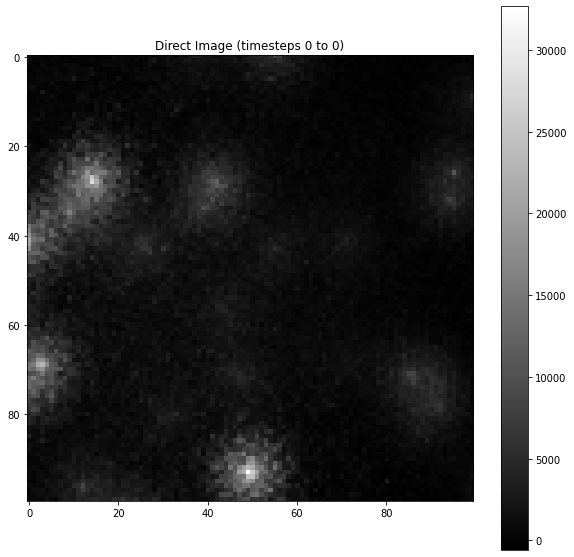

L2 Norm: 322872.5
Max val: 32673.8359375


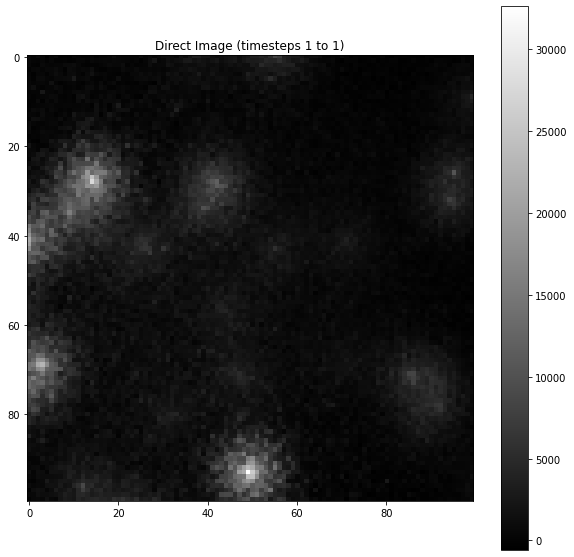

L2 Norm: 322949.125
Max val: 32587.833984375


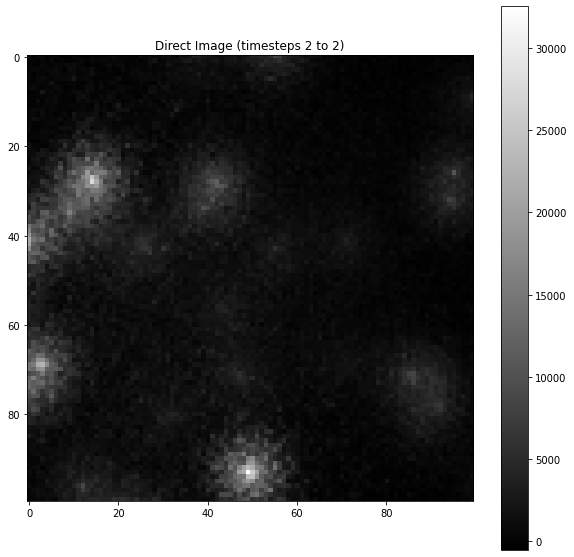

L2 Norm: 322909.09375
Max val: 32551.673828125


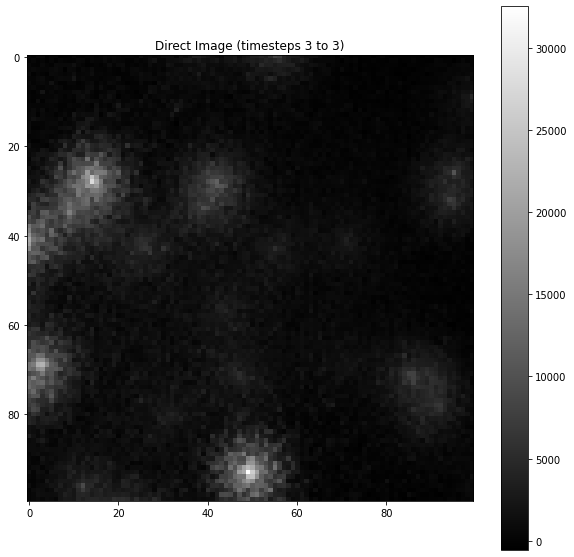

L2 Norm: 322826.1875
Max val: 32532.779296875


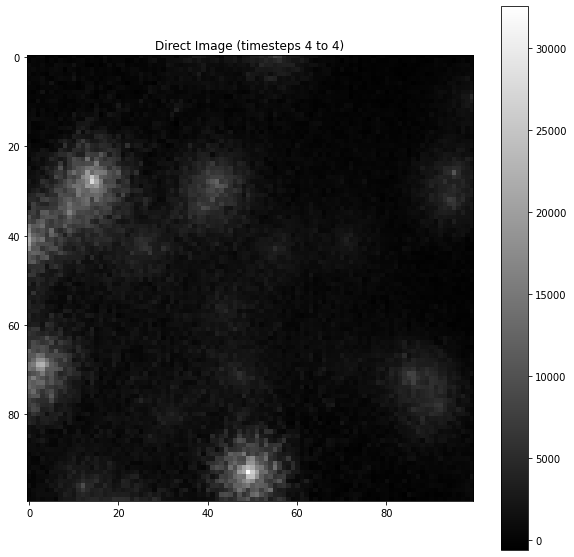

L2 Norm: 322791.21875
Max val: 32551.3125


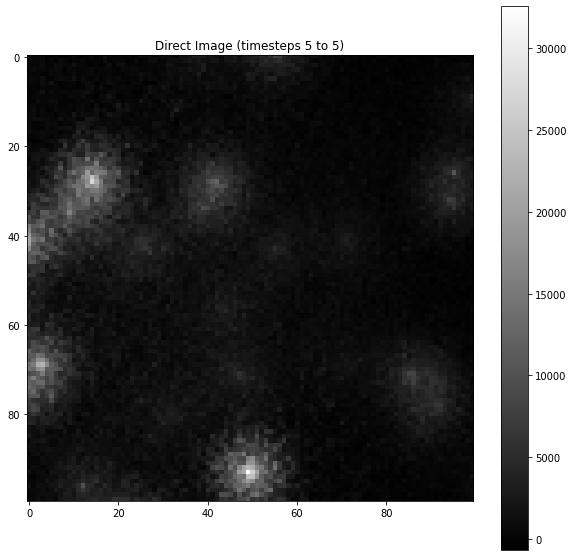

L2 Norm: 322770.5625
Max val: 32543.626953125


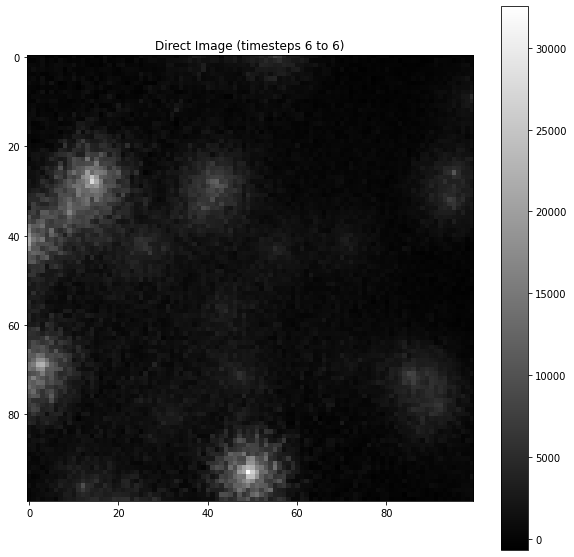

L2 Norm: 322766.3125
Max val: 32535.91015625


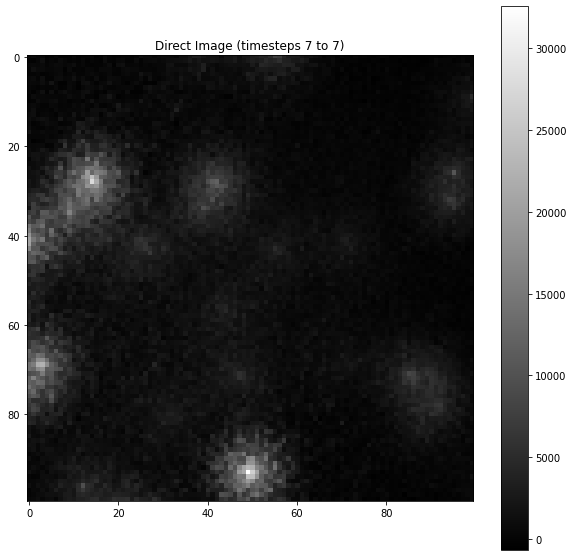

L2 Norm: 322735.25
Max val: 32568.3515625


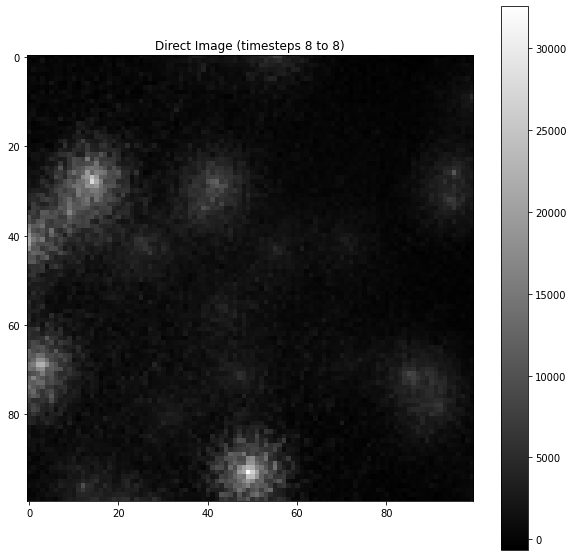

L2 Norm: 322627.8125
Max val: 32546.0546875


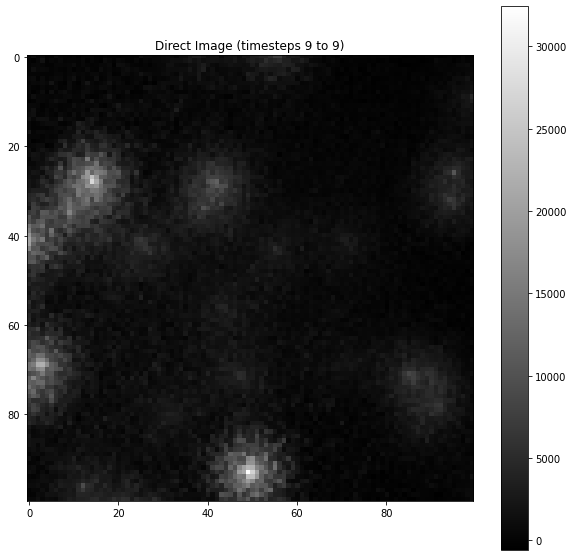

L2 Norm: 322513.84375
Max val: 32429.009765625


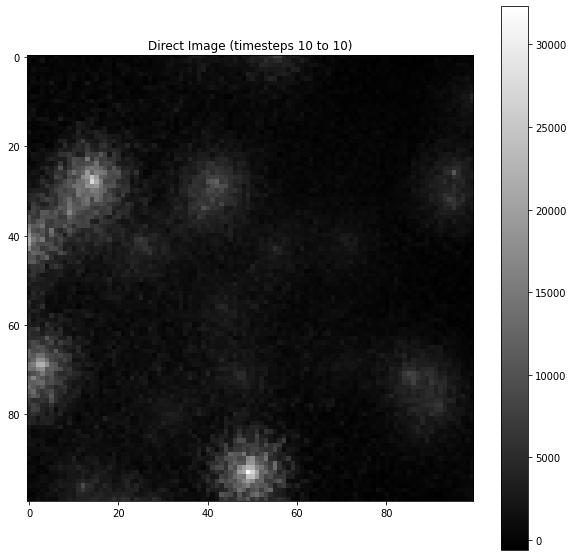

L2 Norm: 322444.875
Max val: 32305.271484375


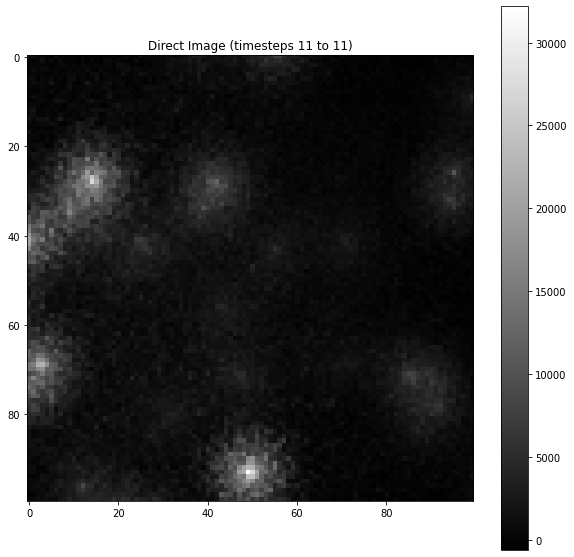

L2 Norm: 322438.59375
Max val: 32191.904296875


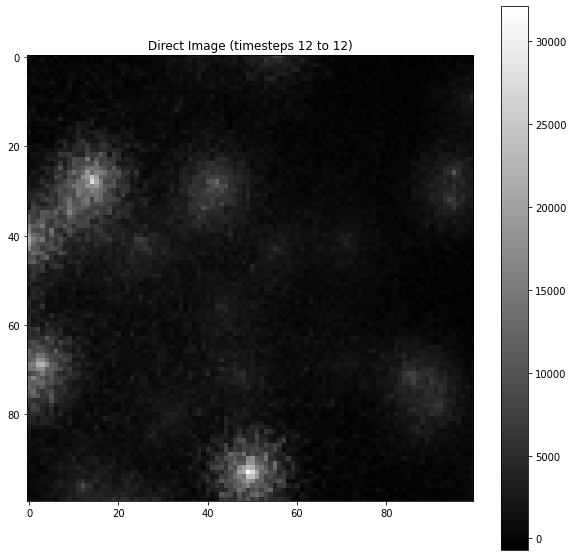

L2 Norm: 322467.09375
Max val: 32127.916015625


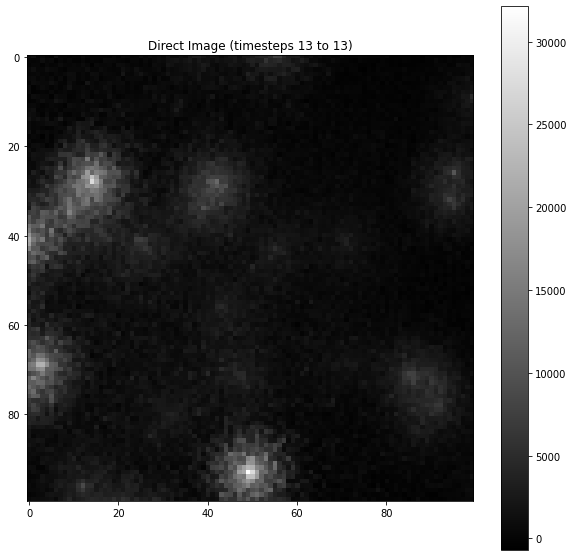

L2 Norm: 322490.40625
Max val: 32140.638671875


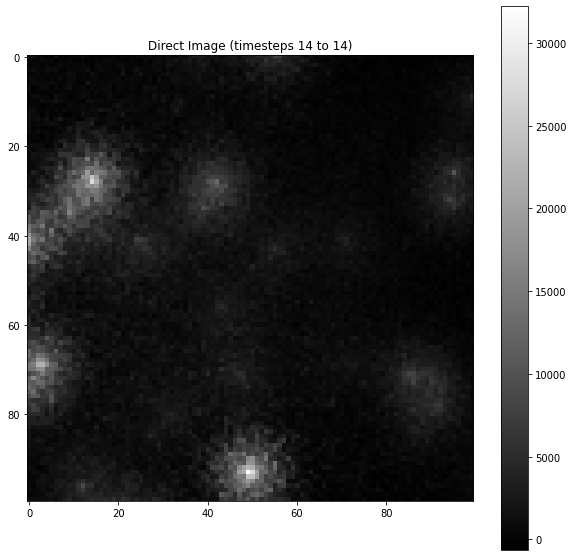

L2 Norm: 322534.96875
Max val: 32215.3671875


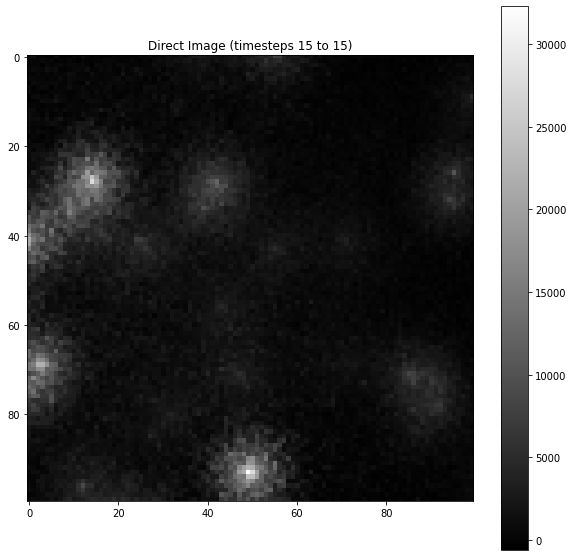

L2 Norm: 322574.5
Max val: 32276.94140625


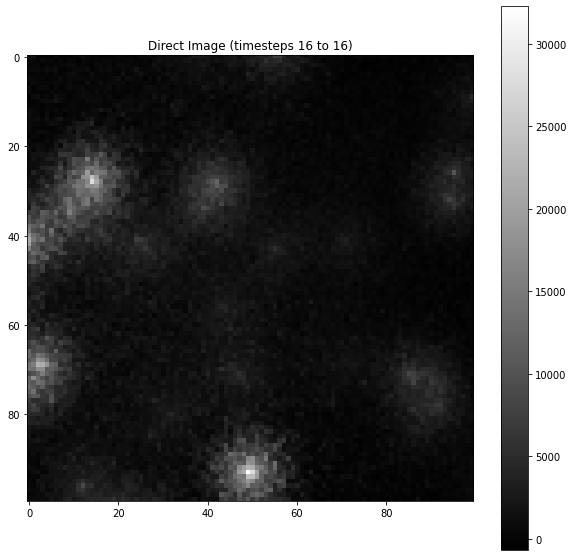

L2 Norm: 322540.125
Max val: 32291.064453125


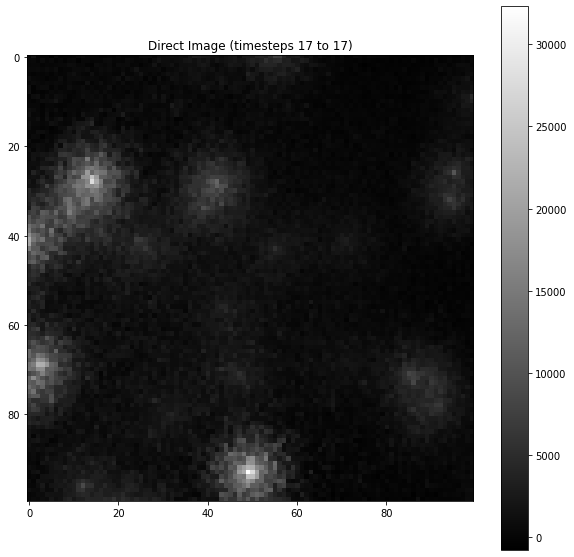

L2 Norm: 322480.5
Max val: 32314.669921875


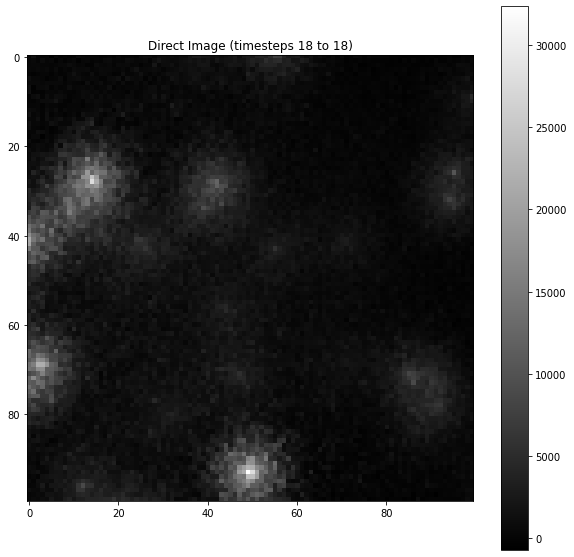

L2 Norm: 322456.71875
Max val: 32364.58203125


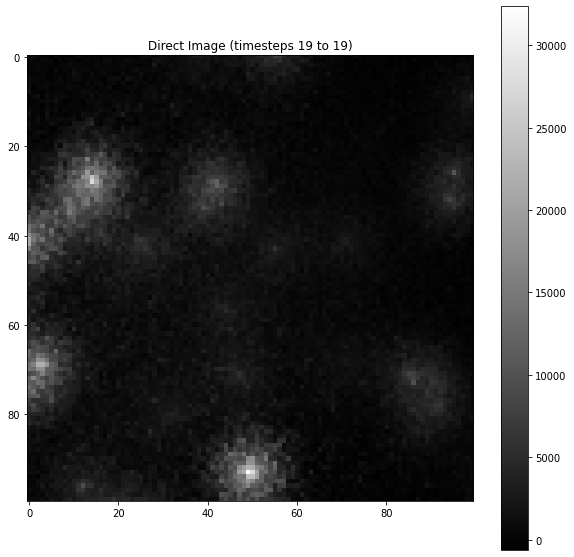

L2 Norm: 322428.46875
Max val: 32377.140625


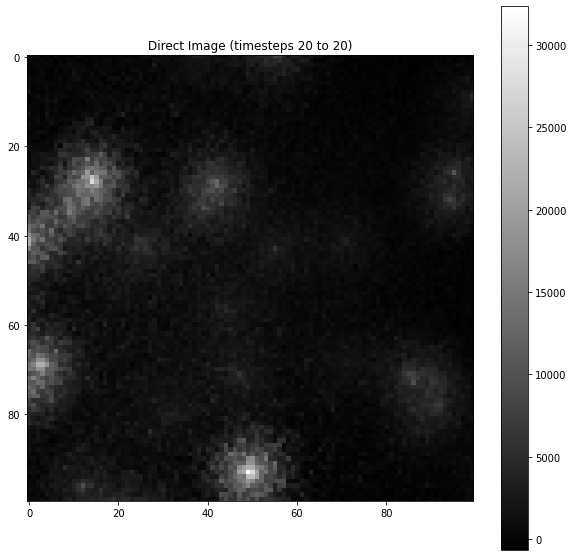

L2 Norm: 322395.8125
Max val: 32350.9609375


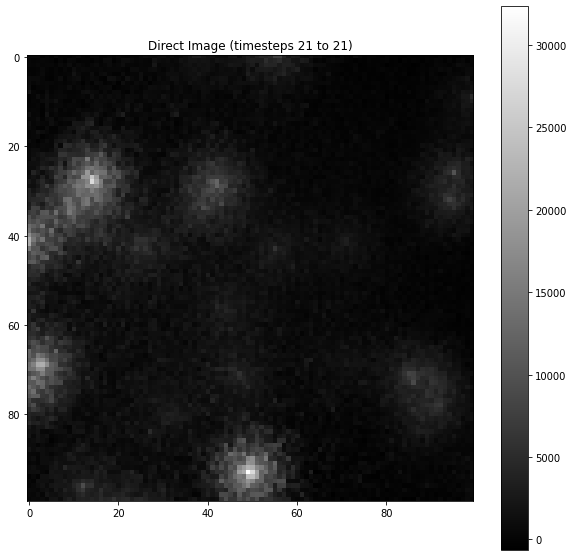

L2 Norm: 322398.28125
Max val: 32339.736328125


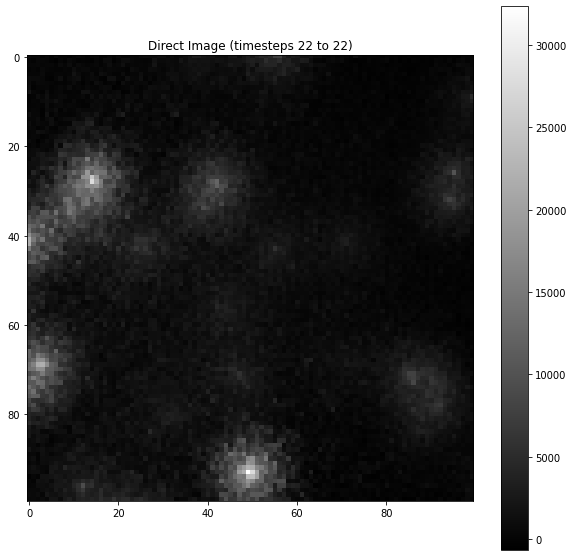

L2 Norm: 322411.25
Max val: 32346.63671875


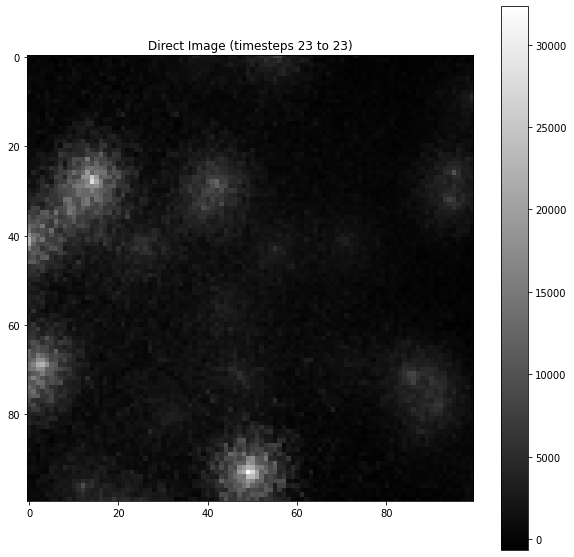

L2 Norm: 322409.46875
Max val: 32333.994140625


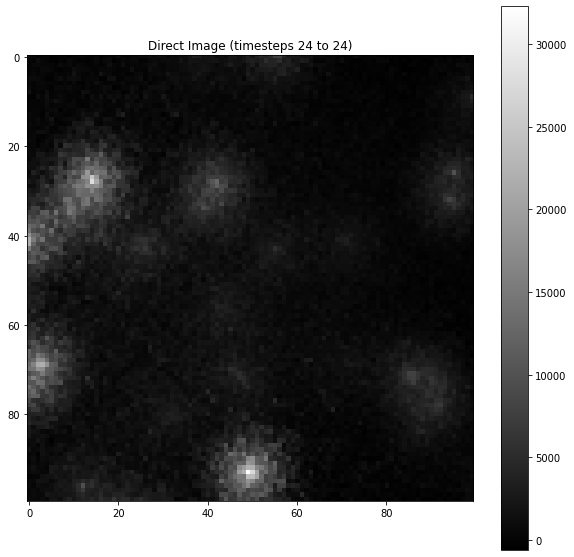

L2 Norm: 322377.46875
Max val: 32293.912109375


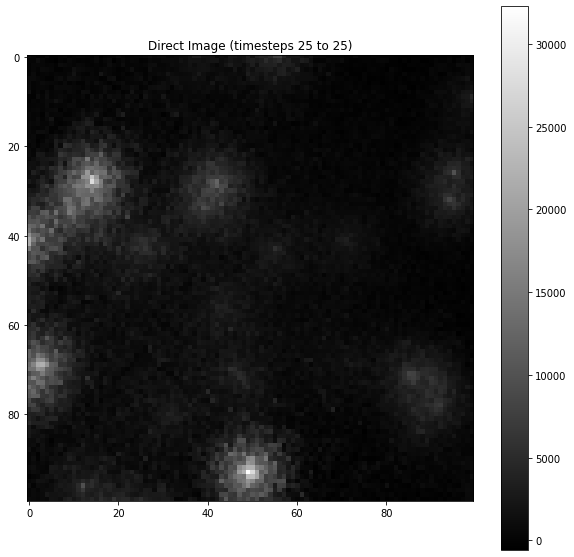

L2 Norm: 322319.53125
Max val: 32276.29296875


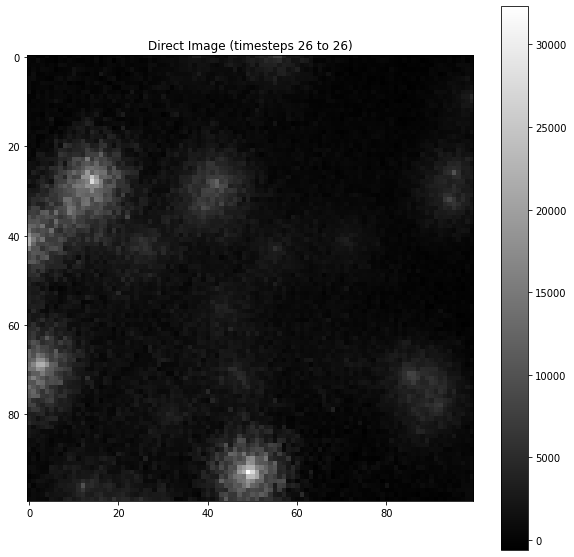

L2 Norm: 322277.53125
Max val: 32314.708984375


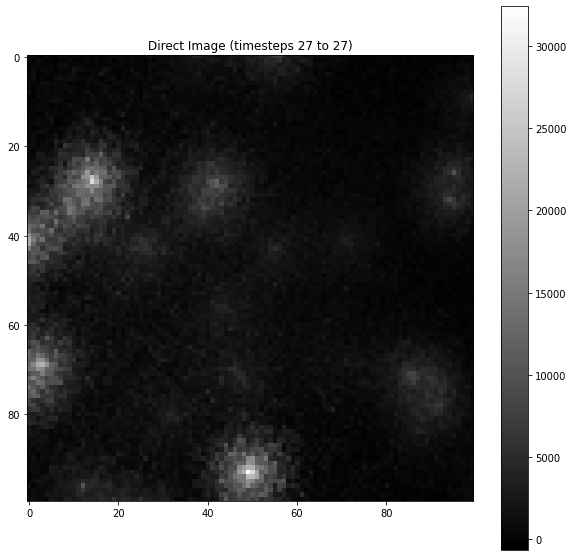

L2 Norm: 322217.0625
Max val: 32439.830078125


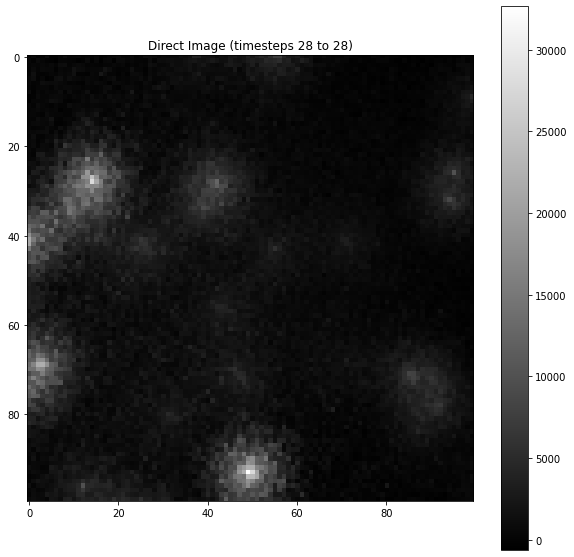

L2 Norm: 322110.1875
Max val: 32650.583984375


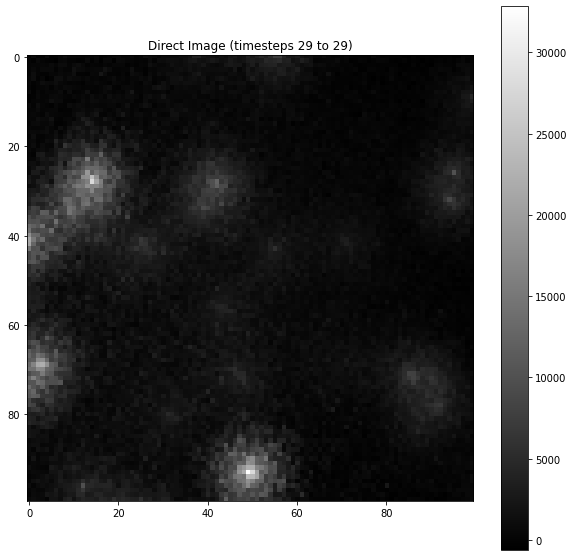

L2 Norm: 322001.40625
Max val: 32841.91796875
CPU times: user 7.99 s, sys: 4.66 s, total: 12.6 s
Wall time: 8.07 s


In [4]:
%%time

vis_per_timestep = num_baselines * num_chans
uvw_per_timestep = vis_per_timestep # only valid for single channel, needs refactoring later

# print(f"Vis per timestep: {vis_per_timestep}")

for batch in np.arange(num_images_to_generate):
    
    timestep_range_start = batch * timesteps_per_image
    timestep_range_end = timestep_range_start + timesteps_per_image
    
    vis_batch_start = timestep_range_start * vis_per_timestep
    vis_batch_end = vis_batch_start + timesteps_per_image * vis_per_timestep
    uvw_batch_start = timestep_range_start * vis_per_timestep
    uvw_batch_end = uvw_batch_start + timesteps_per_image * vis_per_timestep

    # Device preparation
    vis_real_gpu = cp.asarray(visibilities_host[vis_batch_start:vis_batch_end, 0])
    vis_imag_gpu = cp.asarray(visibilities_host[vis_batch_start:vis_batch_end, 1])
    
    # print(f"Sample vis from current batch: vis real imag => {vis_real_gpu[0]} {vis_imag_gpu[0]}")

    u_coords_gpu = cp.asarray(uvw_coords_host[uvw_batch_start:uvw_batch_end, 0])
    v_coords_gpu = cp.asarray(uvw_coords_host[uvw_batch_start:uvw_batch_end, 1])
    w_coords_gpu = cp.asarray(uvw_coords_host[uvw_batch_start:uvw_batch_end, 2])

    # print(f"Sample uvw from current batch: uvw => {u_coords_gpu[0]} {v_coords_gpu[0]} {w_coords_gpu[0]}")
    
    if right_ascension:
        u_coords_gpu *= -1.0
        w_coords_gpu *= -1.0

    image_gpu = cp.zeros((image_size, image_size), dtype=np.float32)
    
    # Kernel execution
    direct_imaging_kernel(kernel_blocks, kernel_threads, (
        image_gpu,
        vis_real_gpu,
        vis_imag_gpu,
        u_coords_gpu,
        v_coords_gpu,
        w_coords_gpu,
        np.uintc(uvw_per_timestep * timesteps_per_image),
        np.uintc(num_chans),
        np.uintc(image_size),
        np.float32(image_cell_size_radians),
        np.float32(freq_start_hz),
        np.float32(freq_bandwidth),
        np.float32(np.pi),
        np.float32(299792458.0)
    ))

    # Obtain generated image
    image_host = cp.asnumpy(image_gpu)
    show_image(image_host, f"Direct Image (timesteps {timestep_range_start} to {timestep_range_end - 1})")
    # plt.plot(image_host[image_size//2, :])
    # plt.show()
    print(f"L2 Norm: {np.linalg.norm(image_host)}")
    print(f"Max val: {np.max(image_host)}")
    
    if generate_psf:
        image_host.tofile(dataset_folder + f"images/direct_psf_ts_{timestep_range_start}_{timestep_range_end - 1}_{image_size}x{image_size}.bin")
    else:
        image_host.tofile(dataset_folder + f"images/direct_image_ts_{timestep_range_start}_{timestep_range_end - 1}_{image_size}x{image_size}.bin")

In [5]:
# # Comparing against all timesteps IDFT from C implementation
# reference = np.fromfile("../data/direct_image_ts_0_4.bin", dtype=np.float32)
# reference = reference.reshape(50, 50)
# show_image(reference, "Reference from C")
# print(f"Reference max: {np.max(reference)}")
# print(f"Generated max: {np.max(image_host)}")

# print(f"Reference l2: {np.linalg.norm(reference)}")
# print(f"Generated l2: {np.linalg.norm(image_host)}")

# # plt.plot(reference[50])
# # plt.plot(image_host[50])
# # plt.show()

# show_image(np.absolute(reference - image_host), "Abs diff")

# print(rrmse(normalise(image_host), normalise(reference)))

In [6]:
# Cupy clean up (memory wont fully dealloc until python instance is dead)
mempool = cp.get_default_memory_pool()
mempool.free_all_blocks()